In [56]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import nltk

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from bs4 import BeautifulSoup
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
API_KEY = "QCC4AQUW1ZKX4T7P"
symbol = "AAPL"

In [59]:
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={API_KEY}&datatype=csv"

In [60]:
response = requests.get(url)

In [61]:
# print response
if response.status_code == 200:
    with open(f'{symbol}_stock_data.csv', 'wb') as file:
        file.write(response.content)
    print(f"Data saved to {symbol}_stock_data.csv")
else:
    print(f"Failed to fetch data: {response.status_code}")

Data saved to AAPL_stock_data.csv


In [62]:
# store the data in a pandas dataframe
df = pd.read_csv(f'{symbol}_stock_data.csv', index_col=0, parse_dates=True)

In [63]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
print(df.tail())

               open      high       low   close    volume
timestamp                                                
2025-06-27  201.890  203.2200  200.0000  201.08  73188571
2025-06-30  202.010  207.3900  199.2607  205.17  91912816
2025-07-01  206.665  210.1865  206.1401  207.82  78788867
2025-07-02  208.910  213.3400  208.1400  212.44  67941811
2025-07-03  212.145  214.6500  211.8101  213.55  34955836


In [64]:
# show all column names
print("Column names:", df.columns.tolist())

Column names: ['open', 'high', 'low', 'close', 'volume']


In [65]:
df.tail()

,open,high,low,close,volume
timestamp,,,,,
2025-06-27,201.890,203.2200,200.0000,201.08,73188571
2025-06-30,202.010,207.3900,199.2607,205.17,91912816
2025-07-01,206.665,210.1865,206.1401,207.82,78788867
2025-07-02,208.910,213.3400,208.1400,212.44,67941811
2025-07-03,212.145,214.6500,211.8101,213.55,34955836


In [66]:
# Add multiple indicators
df.ta.rsi(append=True)                      # RSI
df.ta.macd(append=True)                     # MACD (MACDEXT style)
df.ta.ema(length=20, append=True)           # EMA20
df.ta.sma(length=50, append=True)           # SMA50
df.ta.obv(append=True)                      # On Balance Volume
df.ta.bbands(append=True)                   # Bollinger Bands
df.ta.cci(append=True)                      # CCI
df.ta.atr(append=True)                      # ATR

# Clean up: Drop NaN values created by indicators (lookback periods)
df.dropna(inplace=True)

In [67]:
# Calculate ADX with 14-day period (default)
adx = ta.adx(df['high'], df['low'], df['close'])

# Merge into your main DataFrame
df = pd.concat([df, adx], axis=1)

# Optional: Simplify naming
df.rename(columns={
    'ADX_14': 'ADX',
    'DMP_14': 'DI+',
    'DMN_14': 'DI-'
}, inplace=True)

In [68]:
def trend_direction(row):
    if row['ADX'] > 25:
        if row['DI+'] > row['DI-']:
            return 1   # strong uptrend
        else:
            return -1  # strong downtrend
    return 0  # no clear trend

df['trend_signal'] = df.apply(trend_direction, axis=1)

In [69]:
# Calculate MA
df['MA100'] = df['close'].rolling(100).mean()
df['MA200'] = df['close'].rolling(200).mean()
df['MA_signal'] = (df['MA100'] > df['MA200']).astype(int)

# Drop NA
df = df.dropna()

In [70]:
# 1️⃣ Select features
features = ['open', 'high', 'low', 'close', 'volume',
            'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
            'EMA_20', 'SMA_50', 'OBV', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0',
            'BBB_5_2.0', 'BBP_5_2.0', 'CCI_14_0.015', 'ATRr_14',
            'ADX', 'DI+', 'DI-', 'trend_signal', 'MA100', 'MA200', 'MA_signal']

# 2️⃣ Scaling features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

# 3️⃣ Create sequences
X = []
y = []

sequence_length = 60  # last 60 days
target_col_index = features.index('close')  # we'll predict next 'close' price

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])
    y.append(scaled_data[i][target_col_index])  # predicting close price

X, y = np.array(X), np.array(y)

# 4️⃣ Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [82]:
# Number of test samples
num_test = len(y_test)

# Start from sequence_length + training size
test_dates = df.index[-num_test:]

In [83]:
num_test

1845

In [71]:
# remove target column from X
X_train = np.delete(X_train, target_col_index, axis=2)
X_test = np.delete(X_test, target_col_index, axis=2)


In [76]:
def create_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Predicting the closing price

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [77]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 128)           78848     
                                                                 
 dropout_6 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 128,321
Trainable params: 128,321
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Delete the model object
# del model

# Clear the Keras backend session to release memory and reset states
# K.clear_session()

In [78]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
122/122 [==============================] - 8s 49ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 2/30
122/122 [==============================] - 5s 41ms/step - loss: 0.0026 - val_loss: 4.3483e-04
Epoch 3/30
122/122 [==============================] - 5s 39ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/30
122/122 [==============================] - 5s 39ms/step - loss: 0.0017 - val_loss: 1.2201e-04
Epoch 5/30
122/122 [==============================] - 5s 39ms/step - loss: 0.0017 - val_loss: 6.0827e-05
Epoch 6/30
122/122 [==============================] - 5s 39ms/step - loss: 0.0017 - val_loss: 8.3291e-05
Epoch 7/30
122/122 [==============================] - 5s 39ms/step - loss: 0.0013 - val_loss: 3.1599e-04
Epoch 8/30
122/122 [==============================] - 5s 40ms/step - loss: 0.0015 - val_loss: 1.9842e-04
Epoch 9/30
122/122 [==============================] - 5s 39ms/step - loss: 0.0013 - val_loss: 1.0372e-04
Epoch 10/30
122/122 [==============================] - 5s 39ms/

In [81]:
model.save('stock_trend_model.h5')

58/58 [==============================] - 1s 15ms/step


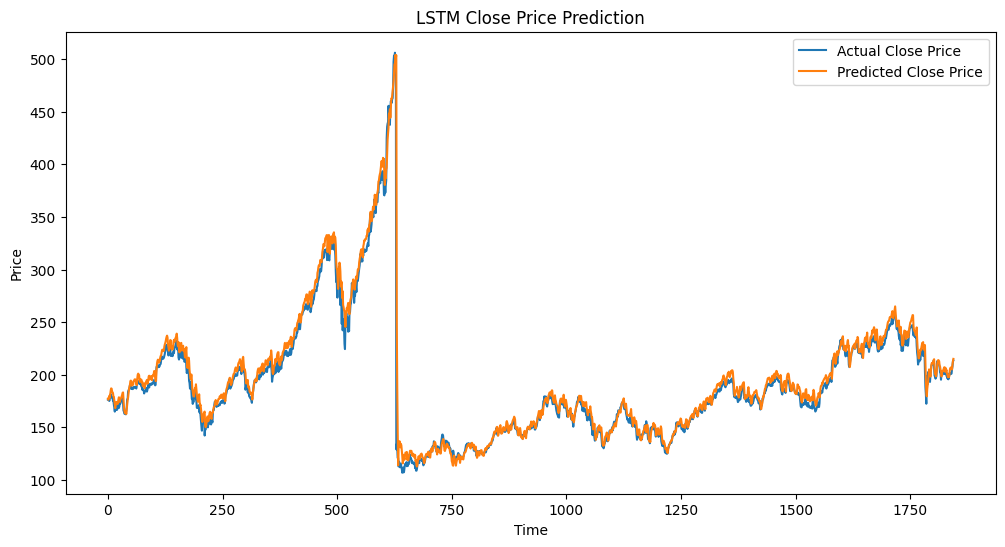

In [79]:
# Predict
y_pred = model.predict(X_test)

# Inverse transform (optional)
# To get actual prices, you must inverse only the close column
# So extract only that column from original scaled data
close_scaler = MinMaxScaler()
close_scaler.fit(df[['close']])
y_pred_actual = close_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Close Price')
plt.plot(y_pred_actual, label='Predicted Close Price')
plt.legend()
plt.title('LSTM Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


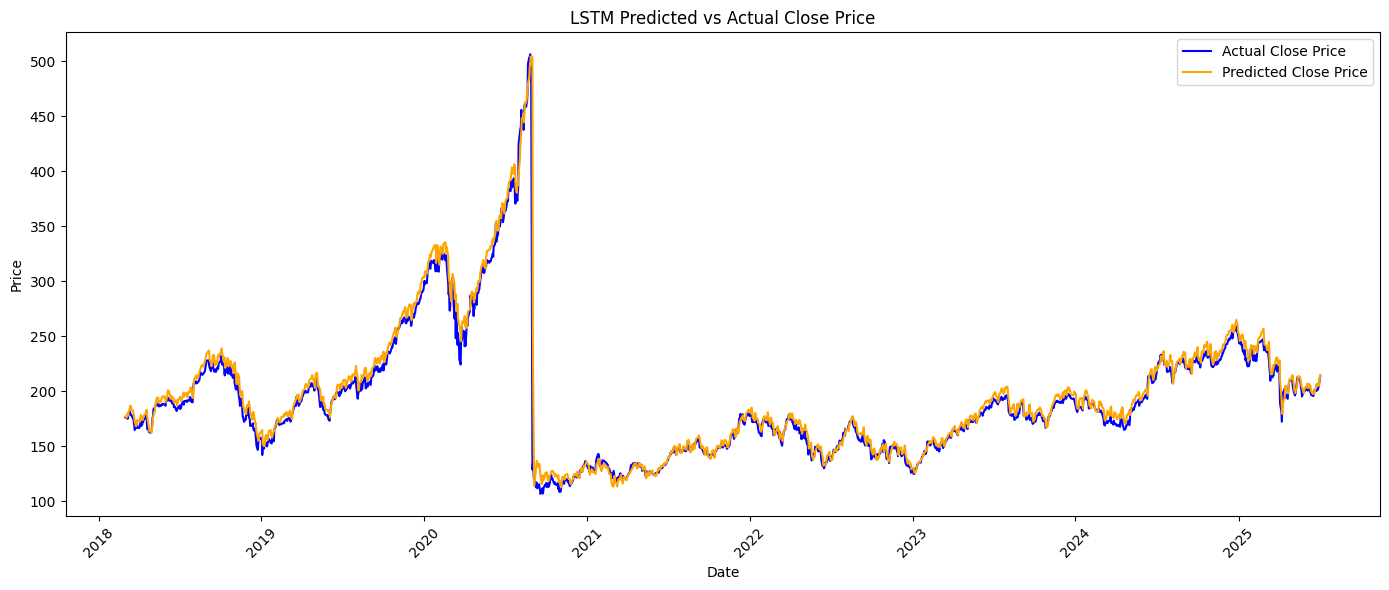

In [84]:
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Actual Close Price', color='blue')
plt.plot(test_dates, y_pred_actual, label='Predicted Close Price', color='orange')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("LSTM Predicted vs Actual Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [80]:
# Inverse transform to get actual prices
y_pred_actual = close_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Flatten arrays
y_pred_actual = y_pred_actual.flatten()
y_test_actual = y_test_actual.flatten()

# 1️⃣ MAE
mae = mean_absolute_error(y_test_actual, y_pred_actual)

# 2️⃣ MSE
mse = mean_squared_error(y_test_actual, y_pred_actual)

# 3️⃣ RMSE
rmse = np.sqrt(mse)

# 4️⃣ R^2 Score
r2 = r2_score(y_test_actual, y_pred_actual)

# 5️⃣ MAPE (Optional - Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100

# 🔍 Print Results
print("📊 Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error):  {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score (R2): {r2:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


📊 Evaluation Metrics:
MAE  (Mean Absolute Error): 5.5913
MSE  (Mean Squared Error):  133.2524
RMSE (Root Mean Squared Error): 11.5435
R² Score (R2): 0.9621
MAPE (Mean Absolute Percentage Error): 3.00%


In [ ]:
# Filter data from the last 3 years
cutoff_date = datetime.now() - timedelta(days=3*365)
df_recent = df[df.index >= cutoff_date]

print(df_recent.head())

                 open       high        low      close  volume      RSI  \
timestamp                                                                 
2025-07-04  3401.1001  3426.0000  3388.6499  3420.9500  170988  47.6243   
2025-07-03  3434.8999  3435.0000  3398.1499  3400.7500  113506  44.2725   
2025-07-02  3450.0500  3489.8501  3420.1001  3423.3501   54493  47.4255   
2025-07-01  3460.9500  3485.0000  3414.4500  3429.4500  221565  48.2875   
2025-06-30  3444.9500  3465.0000  3430.1499  3461.0500   80588  52.9134   

                 SMA        EMA  Real Upper Band  Real Middle Band  \
timestamp                                                            
2025-07-04  3434.860  3436.4619        3501.4278         3440.5700   
2025-07-03  3437.185  3444.3201        3503.7413         3438.8075   
2025-07-02  3438.565  3446.4134        3506.7391         3437.3675   
2025-07-01  3445.995  3445.6053        3508.7152         3435.2275   
2025-06-30  3450.900  3442.1954        3510.5360      

In [ ]:
def get_news_headlines(keyword="TCS", num_days=30):
    headlines = {}

    for i in range(num_days):
        date = datetime.now() - timedelta(days=i)
        formatted_date = date.strftime('%Y-%m-%d')
        
        # Google News RSS (can filter date later)
        url = f"https://news.google.com/rss/search?q={keyword}+when:{i}d"
        r = requests.get(url)
        soup = BeautifulSoup(r.content, features="html.parser")
        items = soup.findAll("item")

        headlines[formatted_date] = [item.title.text for item in items]

    return headlines


In [ ]:
def compute_daily_sentiment(headlines_dict):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = {}

    for date, titles in headlines_dict.items():
        scores = [analyzer.polarity_scores(title)['compound'] for title in titles]
        avg_score = sum(scores) / len(scores) if scores else 0
        sentiment_scores[date] = avg_score

    return sentiment_scores

In [ ]:
headline_data = get_news_headlines("Reliance Industry", num_days=365*3)
sentiment_scores = compute_daily_sentiment(headline_data)

sentiment_df = pd.DataFrame(list(sentiment_scores.items()), columns=['Date', 'Sentiment'])
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df.set_index('Date', inplace=True)

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
